## Install package

In [1]:
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 248 kB 8.3 MB/s 
  Attempting uninstall: stable-baselines
    Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


## Create data

In [10]:
# data from (0,10) 

# 0: [0,0,0,0,0]
# 1: [0,0,0,0,1]
# 10:[0,1,0,1,0]
#...
# 31:[1,1,1,1,1]
import numpy as np
def decimalToBinary(n):
  base = "{0:b}".format(int(n))
  if (len(base)) < 5:
    str_0 = '0' * (5 -len(base))
    final_str =  str_0 + base
    return [int(i) for i in list(final_str)]
  return [int(i) for i in list(base)]

for i in range(0,32):
  lst_res = decimalToBinary(i)
  np_arr = np.array(lst_res)
  np.save('/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/array_test/group1/{}.npy'.format(i), np_arr)
  np.save('/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/array_test/group2/{}.npy'.format(i), np_arr)


In [3]:
test_np =np.load('/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/array_test/group1/19.npy')
print(test_np)

[1 0 0 1 1]


## Create environment

In [35]:
# utils 
def get_all_vectors():
  lst_np = []
  for i in range(0,32):
    vector = np.load('/content/drive/MyDrive/Colab Notebooks/RLWithGraphEntityAlignment/array_test/group1/{}.npy'.format(i))
    lst_np.append({'num': i, 'vector': vector})
  return lst_np

def get_random_vectors(lst_vectors, seed):
  res_vector = lst_vectors.copy()
  random.Random(seed).shuffle(res_vector)
  return res_vector

def get_k_nearest_items(lst_group_vector_1, lst_group_vector_2, k):
  '''
    Get 5 vector closest to vector_1
    E.g: vector_1 = 3
    Return 12345 in lst_group_vector_2 => lay d xong sort 
  '''
  # lấy num của first item vector_1
  num = lst_group_vector_1[0]['num']

  # loop và đặt tại vị trí theo thứ tự khoảng cách giảm dần 
  sorted_vector_2 = sorted(lst_group_vector_2, key=(lambda t: abs(t['num'] - num)) )
  res = sorted_vector_2[0:k]
  print('res: {}'.format(res))
  _shuffle = random.randint(0,10)
  if _shuffle <= 1 and len(res) >=2:
    res[0], res[1] = res[1], res[0]
  return res

In [30]:
import gym
import numpy as np
from gym import spaces
import random

class SequentialMatchingEnv(gym.Env): 
  """
  Custom Environment for Binary Scheme
  """
  # Because of google colab, we cannot implement the GUI ('human' render mode)
  metadata = {'render.modes': ['console']}

  # Define constants for action
  MATCH = 1
  UNMATCH = 0  
  lst_vectors = get_all_vectors()

  def __init__(self, vector_size=32, k_nearest=5):
    super(SequentialMatchingEnv, self).__init__()

    self.seed = random.randint(0,100)

    # init no vectors
    self.vector_size = vector_size
    self.k_nearest = k_nearest
    
    # init total reward
    self.total_reward = 0 

    # define action and observation space 
    n_actions = 2
    self.action_space = spaces.Discrete(n_actions)

    # observation will be the source vector and the target vector with each (1,5)vector 
    self.observation_space =  spaces.Box(low=0, high=1, 
                                          shape=(2,5), dtype=np.float16)
    
  def reset(self):
    """
      Important: The observation must be numpy array 
      : return: (np.array)
    """
    self.seed = random.randint(0,100)
    # randomize 2 group vector with random order and k_nearest corresponding to first item in group1
    self.random_vector_group1 = get_random_vectors(self.lst_vectors, self.seed)
    self.random_vector_group2 = get_random_vectors(self.lst_vectors, self.seed+1)
    self.k_nearest_list = [] 

    print('random_vector_group1: {}'.format(self.random_vector_group1))
    print('random_vector_group2: {}'.format(self.random_vector_group2))


    # init state [ex, ey] 
    self.state = np.array([np.array(self.random_vector_group1[0]['vector']), 
                          np.array(self.random_vector_group2[0]['vector'])]).astype(np.float16)

    print('state: {}'.format(self.state))


    # trả về state đầu tiên 
    return self.state

  def step(self, action):

    self.k_nearest_list = get_k_nearest_items(self.random_vector_group1, self.random_vector_group2, self.k_nearest)

    # if took action, move to the next step
    if action == self.MATCH:
      # if match pop head from group vector 1 and head from k nearest(head_1) 
      head_1 = self.random_vector_group1.pop(0)
      head_2 = self.k_nearest_list.pop(0)
      
      for item in self.random_vector_group2: # delete head of k nearest from group_vector_2
        if item['num'] == head_2['num']: self.random_vector_group2.remove(item) 

      # check value if true match
      if head_1['num'] == head_2['num']: score = 1
      # if false match then score += 0, then do nothing
      elif head_1['num'] != head_2['num']: score = 0  

    elif action == self.UNMATCH:
      # if mismatch pop head of group vector 2 
      head_1 = self.random_vector_group1[0]
      head_2 = self.k_nearest_list.pop(0)
      # if true mismatch
      if head_1['num'] != head_2['num']: score = 0 
      # if false mismatch 
      elif head_1['num'] == head_2['num']: score = -10

      if len(self.k_nearest_list) == 0: self.random_vector_group1.pop(0)
    else:
      raise ValueError("Received invalid action={} which is not part of the action space".format(action))
    #info
    # info = {'log': 'Check source-{} and target-{} with action-{}'.format(head_1['num'], head_2['num'], action)}
    info = {}

    done = bool(len(self.random_vector_group1) == 0) # neu pop het group 1 thi done 

    if len(self.random_vector_group1) == 0:
      next_state = None
    else:
      next_state = np.array([np.array(self.random_vector_group1[0]['vector']), 
                            np.array(self.random_vector_group2[0]['vector'])]).astype(np.float16)

    return next_state, score, done, info


## Validate the environment


In [26]:
from stable_baselines.common.env_checker import check_env

In [ ]:
env = SequentialMatchingEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)
print(env.action_space)
print((env.observation_space))

## Testing environment

### Hard-code action

In [36]:
env = SequentialMatchingEnv()
MATCH = 1


# Hardcoded best agent: always match!

obs = env.reset()
rewards_lst = [] 
max_steps = 500
episodes = 100


for ep in range(episodes):
  total_reward = 0
  step = 0

  while step < max_steps:
    
    print("Episode {}/step {}".format(ep ,step + 1))
    step += 1

    # define policy and action
    action = MATCH

    # get environment state 
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)
    
    # add reward 
    total_reward += reward 

    if done:
      step = max_steps
      obs = env.reset()
      print("Goal reached!", "reward=", reward)
      continue
  rewards_lst.append((ep, total_reward))


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
Episode 62/step 5
res: [{'num': 14, 'vector': array([0, 1, 1, 1, 0])}, {'num': 15, 'vector': array([0, 1, 1, 1, 1])}, {'num': 13, 'vector': array([0, 1, 1, 0, 1])}, {'num': 16, 'vector': array([1, 0, 0, 0, 0])}, {'num': 17, 'vector': array([1, 0, 0, 0, 1])}]
obs= [[1. 0. 0. 0. 1.]
 [0. 1. 0. 1. 0.]] reward= 1 done= False
Episode 62/step 6
res: [{'num': 17, 'vector': array([1, 0, 0, 0, 1])}, {'num': 18, 'vector': array([1, 0, 0, 1, 0])}, {'num': 16, 'vector': array([1, 0, 0, 0, 0])}, {'num': 15, 'vector': array([0, 1, 1, 1, 1])}, {'num': 19, 'vector': array([1, 0, 0, 1, 1])}]
obs= [[1. 1. 0. 1. 1.]
 [0. 1. 0. 1. 0.]] reward= 0 done= False
Episode 62/step 7
res: [{'num': 27, 'vector': array([1, 1, 0, 1, 1])}, {'num': 28, 'vector': array([1, 1, 1, 0, 0])}, {'num': 29, 'vector': array([1, 1, 1, 0, 1])}, {'num': 25, 'vector': array([1, 1, 0, 0, 1])}, {'num': 24, 'vector': array([1, 1, 0, 0, 0])}]
obs= [[1. 1. 0. 0. 1.]
 [0. 1. 0. 1. 0

**Visualize rewards**

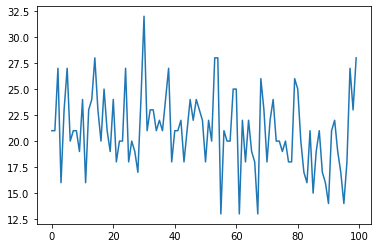

In [37]:
import matplotlib.pyplot as plt 
plt.plot([reward[1] for reward in  rewards_lst])

In [65]:
# rewards_lst[0][1][0]
lst_reward = []
for reward in rewards_lst:
  lst_reward.append(reward[1][0])

print('Mean reward: %.2f +/- %.2f' % (np.mean(lst_reward), np.std(lst_reward) ))

Mean reward: 21.02 +/- 3.36


### Basic explore and exploit

Set explore_p = 0.3 -> random, else MATCH

In [ ]:
env = SequentialMatchingEnv()

obs = env.reset()
rewards_lst = [] 
max_steps = 500
episodes = 100
MATCH = 1
UNMATCH = 0

for ep in range(episodes):
  total_reward = 0
  step = 0

  while step < max_steps:
    
    print("Episode {}/step {}".format(ep ,step + 1))
    step += 1

    # define policy and action
    # Explore or Exploit
    explore_p = 0.3
    if explore_p > np.random.rand():
    # Make a random action
      action = UNMATCH
    else: 
      action = MATCH

    # get environment state 
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)
    
    # add reward 
    total_reward += reward 

    if done:
      step = max_steps
      obs = env.reset()
      print("Goal reached!", "reward=", reward)
      continue

  rewards_lst.append((ep, total_reward))

**Visualize rewards**

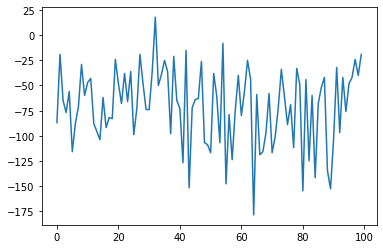

In [39]:
import matplotlib.pyplot as plt 
plt.plot([reward[1] for reward in  rewards_lst])

### MLP Policy

In [40]:
from stable_baselines import DQN, PPO2, A2C, ACKTR, TD3, DQN
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.evaluation import evaluate_policy

In [41]:
# Instantiate the env
env = SequentialMatchingEnv()
# wrap it
env = make_vec_env(lambda: env, n_envs=1)

In [ ]:
model = DQN('MlpPolicy', env, verbose=1).learn(10000)

In [ ]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

In [43]:
obs = env.reset()
# action, _ = model.predict(obs, deterministic=True)

rewards_lst = [] 
max_steps = 10000
episodes = 100

for ep in range(episodes):
  total_reward = 0
  step = 0

  while step < max_steps:
    
    print("Episode {}/step {}".format(ep ,step + 1))
    step += 1

    # define policy and action
    action, _ = model.predict(obs, deterministic=True)

    # get environment state 
    obs, reward, done, info = env.step(action)
    print('obs=', obs, 'reward=', reward, 'done=', done)
    
    # add reward 
    total_reward += reward 

    if done:
      step = max_steps
      obs = env.reset()
      print("Goal reached!", "reward=", reward)
      continue

  rewards_lst.append((ep, total_reward))


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
res: [{'num': 10, 'vector': array([0, 1, 0, 1, 0])}, {'num': 12, 'vector': array([0, 1, 1, 0, 0])}, {'num': 7, 'vector': array([0, 0, 1, 1, 1])}, {'num': 4, 'vector': array([0, 0, 1, 0, 0])}, {'num': 16, 'vector': array([1, 0, 0, 0, 0])}]
obs= [[[0. 0. 0. 1. 0.]
  [1. 1. 0. 1. 1.]]] reward= [1.] done= [False]
Episode 63/step 19
res: [{'num': 2, 'vector': array([0, 0, 0, 1, 0])}, {'num': 1, 'vector': array([0, 0, 0, 0, 1])}, {'num': 4, 'vector': array([0, 0, 1, 0, 0])}, {'num': 0, 'vector': array([0, 0, 0, 0, 0])}, {'num': 7, 'vector': array([0, 0, 1, 1, 1])}]
obs= [[[0. 0. 0. 0. 0.]
  [1. 1. 0. 1. 1.]]] reward= [0.] done= [False]
Episode 63/step 20
res: [{'num': 0, 'vector': array([0, 0, 0, 0, 0])}, {'num': 2, 'vector': array([0, 0, 0, 1, 0])}, {'num': 4, 'vector': array([0, 0, 1, 0, 0])}, {'num': 7, 'vector': array([0, 0, 1, 1, 1])}, {'num': 12, 'vector': array([0, 1, 1, 0, 0])}]
obs= [[[1. 1. 1. 0. 1.]
  [1. 1. 0. 1. 1.]]] rewa

**Visualize rewards**

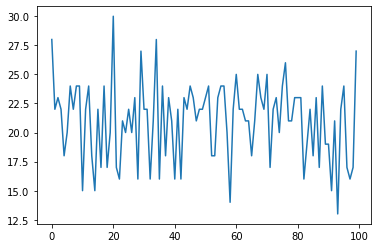

In [44]:
import matplotlib.pyplot as plt 
plt.plot([reward[1] for reward in  rewards_lst])

## Test code

In [39]:
# test 
lst_vectors = get_all_vectors()
random_vector_group1 = get_random_vectors(lst_vectors, 5)
random_vector_group2 = get_random_vectors(lst_vectors, 6)
print(random_vector_group1)
head_1 = random_vector_group1.pop(0)
print(head_1['num'])
k_nearest_list = get_k_nearest_items(random_vector_group1, random_vector_group2, 5)
print(k_nearest_list[0])

[{'num': 4, 'vector': array([0, 0, 1, 0, 0])}, {'num': 12, 'vector': array([0, 1, 1, 0, 0])}, {'num': 24, 'vector': array([1, 1, 0, 0, 0])}, {'num': 2, 'vector': array([0, 0, 0, 1, 0])}, {'num': 28, 'vector': array([1, 1, 1, 0, 0])}, {'num': 10, 'vector': array([0, 1, 0, 1, 0])}, {'num': 18, 'vector': array([1, 0, 0, 1, 0])}, {'num': 27, 'vector': array([1, 1, 0, 1, 1])}, {'num': 21, 'vector': array([1, 0, 1, 0, 1])}, {'num': 9, 'vector': array([0, 1, 0, 0, 1])}, {'num': 19, 'vector': array([1, 0, 0, 1, 1])}, {'num': 8, 'vector': array([0, 1, 0, 0, 0])}, {'num': 6, 'vector': array([0, 0, 1, 1, 0])}, {'num': 17, 'vector': array([1, 0, 0, 0, 1])}, {'num': 13, 'vector': array([0, 1, 1, 0, 1])}, {'num': 15, 'vector': array([0, 1, 1, 1, 1])}, {'num': 29, 'vector': array([1, 1, 1, 0, 1])}, {'num': 3, 'vector': array([0, 0, 0, 1, 1])}, {'num': 5, 'vector': array([0, 0, 1, 0, 1])}, {'num': 1, 'vector': array([0, 0, 0, 0, 1])}, {'num': 7, 'vector': array([0, 0, 1, 1, 1])}, {'num': 14, 'vector':